In [1]:
!kaggle datasets download -d abrahman97/plant-diseases-augmented


Dataset URL: https://www.kaggle.com/datasets/abrahman97/plant-diseases-augmented
License(s): unknown
 99% 1.41G/1.42G [00:20<00:00, 97.3MB/s]
100% 1.42G/1.42G [00:20<00:00, 73.8MB/s]


In [2]:
!unzip /content/plant-diseases-augmented.zip

Streaming output truncated to the last 5000 lines.
  inflating: plant disease/val/Soybean___healthy/53aaa1aa-050f-4a89-a568-750c59fceb65___RS_HL 2854.JPG  
  inflating: plant disease/val/Soybean___healthy/53ab5ad3-94d3-43d6-8636-6f738354d2c6___RS_HL 5999.JPG  
  inflating: plant disease/val/Soybean___healthy/53e5786d-66cb-4bb0-87ca-4a3530872d74___RS_HL 7329.JPG  
  inflating: plant disease/val/Soybean___healthy/54220b9c-9655-47bf-9f0c-7abaf2e049d8___RS_HL 4701.JPG  
  inflating: plant disease/val/Soybean___healthy/54610bc6-0575-4bae-8989-47e0771a393e___RS_HL 7460.JPG  
  inflating: plant disease/val/Soybean___healthy/55a51479-8ae8-42ee-af7d-15ba3e2d7f0e___RS_HL 5263.JPG  
  inflating: plant disease/val/Soybean___healthy/55d0c256-8b4f-4dad-b626-8db76b445476___RS_HL 3216.JPG  
  inflating: plant disease/val/Soybean___healthy/561d3eaf-4ff0-4580-9958-55494bf3a88b___RS_HL 6420.JPG  
  inflating: plant disease/val/Soybean___healthy/56631f0d-8224-4a16-a261-8f3067b61f3b___RS_HL 7331.JPG  
  in

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
def generators(train, val, test):
    train_datagen = ImageDataGenerator(1/255)
    val_datagen = ImageDataGenerator(1/255)
    test_datagen = ImageDataGenerator(1/255)

    train_gen = train_datagen.flow_from_directory(train,
                                                  batch_size=128,
                                                  class_mode='categorical',
                                                  target_size=(150,150))
    val_gen = val_datagen.flow_from_directory(val,
                                              batch_size=128,
                                              class_mode='categorical',
                                              target_size=(150,150))

    test_gen = test_datagen.flow_from_directory(test,
                                                batch_size=128,
                                                class_mode='categorical',
                                                target_size=(150,150))

    return train_gen, val_gen, test_gen

In [5]:
train_path, val_path, test_path = '/content/plant disease/train', '/content/plant disease/val', '/content/plant disease/test'

In [6]:
train_generator, val_generator, test_generator = generators(train_path, val_path, test_path)

Found 32571 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.
Found 10885 images belonging to 38 classes.


In [7]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model
from tensorflow.keras.callbacks import Callback
import tensorflow as tf
from tensorflow.keras.regularizers import l2


In [8]:
def create_model():
    input = Input(shape=(150, 150, 3))
    vgg = VGG16(weights='imagenet', include_top=False, input_tensor=input)
    for layer in vgg.layers:
        layer.trainable = False
    flatten = Flatten()(vgg.output)
    dense1 = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(flatten)
    dropout1 = Dropout(0.15)(dense1)
    dense2 = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(dropout1)
    dropout2 = Dropout(0.15)(dense2)
    dense3 = Dense(38, activation='softmax')(dropout2)
    model = Model(inputs=input, outputs=[dense3])

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=2e-4), metrics=['accuracy'])
    return model


In [9]:
class Mycallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.95 and logs.get('accuracy') > 0.98:
            self.model.stop_training = True
callback = Mycallback()

In [10]:
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch):
    return 2e-4 * (0.98 ** epoch)
lr_scheduler =  LearningRateScheduler(scheduler)


In [11]:
model = create_model()
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,774,118 (60.17 MB)

 Trainable params: 1,059,430 (4.04 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
history = model.fit(train_generator, epochs=1, verbose=1, validation_data=val_generator)

/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


255/255 ━━━━━━━━━━━━━━━━━━━━ 159s 512ms/step - accuracy: 0.3057 - loss: 4.4051 - val_accuracy: 0.6840 - val_loss: 1.5300


In [12]:
history = model.fit(train_generator, epochs=40, verbose=1, validation_data=val_generator, callbacks=[callback, lr_scheduler])

/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


255/255 ━━━━━━━━━━━━━━━━━━━━ 149s 485ms/step - accuracy: 0.2599 - loss: 5.4138 - val_accuracy: 0.6926 - val_loss: 1.4810 - learning_rate: 2.0000e-04
Epoch 2/40
255/255 ━━━━━━━━━━━━━━━━━━━━ 147s 357ms/step - accuracy: 0.6356 - loss: 1.6440 - val_accuracy: 0.8020 - val_loss: 1.0108 - learning_rate: 1.9600e-04
Epoch 3/40
255/255 ━━━━━━━━━━━━━━━━━━━━ 141s 354ms/step - accuracy: 0.7617 - loss: 1.1224 - val_accuracy: 0.8545 - val_loss: 0.8093 - learning_rate: 1.9208e-04
Epoch 4/40
255/255 ━━━━━━━━━━━━━━━━━━━━ 143s 358ms/step - accuracy: 0.8174 - loss: 0.8905 - val_accuracy: 0.8812 - val_loss: 0.6798 - learning_rate: 1.8824e-04
Epoch 5/40
255/255 ━━━━━━━━━━━━━━━━━━━━ 141s 356ms/step - accuracy: 0.8608 - loss: 0.7243 - val_accuracy: 0.8950 - val_loss: 0.6214 - learning_rate: 1.8447e-04
Epoch 6/40
255/255 ━━━━━━━━━━━━━━━━━━━━ 92s 358ms/step - accuracy: 0.8855 - loss: 0.6260 - val_accuracy: 0.9034 - val_loss: 0.5793 - learning_rate: 1.8078e-04
Epoch 7/40
255/255 ━━━━━━━━━━━━━━━━━━━━ 109s 425ms/s

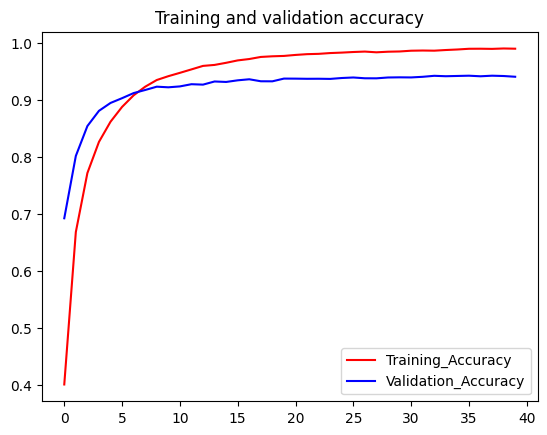

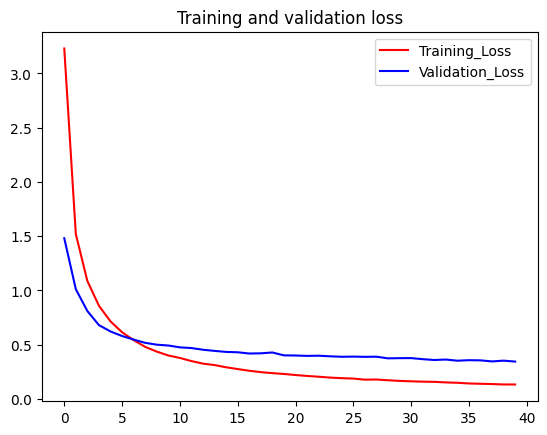

<Figure size 640x480 with 0 Axes>

In [13]:
train_accuracy = history.history.get('accuracy')
val_accuracy = history.history.get('val_accuracy')

train_loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

epochs = range(len(train_accuracy))

plt.plot(epochs, train_accuracy, 'r', label='Training_Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation_Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_loss, 'r', label='Training_Loss')
plt.plot(epochs, val_loss, 'b', label='Validation_Loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.show()

In [15]:
pre = model.evaluate(test_generator)

86/86 ━━━━━━━━━━━━━━━━━━━━ 27s 309ms/step - accuracy: 0.9419 - loss: 0.3652


In [9]:
import numpy as np
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

img_path = 'C:/Users/mahmd/OneDrive/Desktop/test.jpg'
img = image.load_img(img_path, target_size=(150, 150)) 

img_array = image.img_to_array(img)

img_array = np.expand_dims(img_array, axis=0)
    
img_array = preprocess_input(img_array)  

predictions = model.predict(img_array)
    
predicted_class_index = np.argmax(predictions, axis=1)[0]

predicted_class_name = classses[predicted_class_index]
print(f"Predicted class: {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Predicted class: Grape___Black_rot


In [14]:
model.save('p1.keras')
